In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/diploma/data.csv


Импорты. Потом почистить.

In [2]:
# импорт библиотек

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas_profiling
from pandas_profiling import ProfileReport
import os
import sys
import zipfile
import PIL
from PIL import ImageOps, ImageFilter
import re
import ast
from datetime import time, date, datetime
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-paper')

from optuna import *

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, f_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict, cross_val_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import KNNImputer

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn import metrics
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import VotingRegressor
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor, Pool, cv

#image augmentation
#import albumentations as A
#from ImageDataAugmentor.image_data_augmentor import *

# keras
import tensorflow as tf
import tensorflow.keras.backend as K
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.efficientnet import EfficientNetB3
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import MeanAbsolutePercentageError

from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, DataCollatorWithPadding

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 550) # больше колонок

os.environ['PYTHONHASHSEED']=str(42)

In [3]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
ITERATIONS = 200

In [4]:
DIR_DATA  = '../input/diploma/'

In [5]:
data_d = pd.read_csv(DIR_DATA+'data.csv')

# ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ

Вспомогательные функции для обработки признаков и приведения их к численному виду.

In [6]:
def extract_several_digits_comma(stroka,first_digit,len_s,i):
    if i==len_s and not stroka[i].isdigit():
        return (first_digit)
    elif i==len_s and stroka[i].isdigit():
        
        return (10*first_digit+int(stroka[i]))

    else:
        if stroka[i] == ',':
            return extract_several_digits_comma(stroka, first_digit, len_s,i+1)
        elif not stroka[i].isdigit():
            return (first_digit)
        
        
        else:
            return extract_several_digits_comma(stroka,(10*first_digit+int(stroka[i])),len_s,i+1)
        
        
def extract_num_recurr_comma(stroka,len_s,i):

    if i==len_s and not stroka[i].isdigit():
       
        return 0
   
    elif i<len_s and stroka[i].isdigit():
        
        return extract_several_digits_comma(stroka,int(stroka[i]),len_s,i+1)
    
    else: return(extract_num_recurr_comma(stroka,len_s,i+1))  
    
    
# основная функция для нахождения числа. На вход подается только строка, которую нужно обработать.

def extract_num_comma(stroka):

    len_s=len(str(stroka))-1
 
    return extract_num_recurr_comma(str(stroka),len_s,0)
    
    

In [7]:
def extract_several_digits(stroka,first_digit,len_s,i):
    if i==len_s and not stroka[i].isdigit():
        return (first_digit)
    elif i==len_s and stroka[i].isdigit():
        
        return (10*first_digit+int(stroka[i]))
    else:
        if not stroka[i].isdigit():
            return (first_digit)
        else:
            return extract_several_digits(stroka,(10*first_digit+int(stroka[i])),len_s,i+1)
    

def extract_num_recurr(stroka,len_s,i):

    if i==len_s and not stroka[i].isdigit():
       
        return 0
   
    elif i<len_s and stroka[i].isdigit():
        
        return extract_several_digits(stroka,int(stroka[i]),len_s,i+1)
    
    else: return(extract_num_recurr(stroka,len_s,i+1))
        
# основная функция для нахождения числа. На вход подается только строка, которую нужно обработать.
def extract_num(stroka):

    len_s=len(str(stroka))-1
 
    return extract_num_recurr(str(stroka),len_s,0)

# Вспомогательные функции расчета метрик.

In [8]:
# Функция расчета ошибки
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [9]:
# Функция расчета ошибки для логарифмированной целевой переменнной
def mape_log(y_true, y_pred):
    return np.mean(np.abs((np.exp(y_pred)-np.exp(y_true))/np.exp(y_true)))

In [10]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

# Общие сведения, задачи, примерный план работы.

In [11]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

# Задачи на текущем этапе

1. С точки зрения здравого смысле должна быть корреляция между улицей и городом. Возможны проблемы с сочетанием популярности улицы - непопулярности города и наоборот. Что с этим делать пока непонятно.

2. Признак школы объединяет три фрагмента информации: рейтинг школы, удаленность от школы, название школы. С точки зрения здравого смысла, рейтинг и удаленность должны заметно влиять на цену. Проблема с признаком: неряшливая запись, практически невозможно выделить какой-то формат. Пока работаю над ним.

3.  mls_id и MLSID: похоже, одно и то же. Посмотреть распределение значений mls_id, скорее всего, можно будет просто выкинуть. MLSID, наверное, тоже.  # удалено. Скорее всего, на цену не влияет.

4. Признак факты содержит дополнительную информацию. В признаке хорошо выделяется структура: список словарей. Написана функция, выделяющая собственно этот список, в которой проявляется ошибка. Работаю над исправлением.


# Текущая модель

Из предварительной выборки удалены признаки:

private pool

улица

mls_id и MLSID

общий признак школы

общий признак факты

    
# Дальнейшие задачи

1. Обработка признаков школы и факты, добавление новых столбцов в датасет, добавление в модель.

2. Эксперименты с моделями.

3. Провести более точное удаление выбросов целевой переменной, посмотреть результаты.

Удалено, потому что громоздко.

In [12]:
# Быстрый EDA 
#profile = ProfileReport(data_d, title='Dataset Pandas Profiling Report', explorative = True)

In [13]:
#profile

# Анализ целевой переменной.

# Вспомогательная функция извлечения числа из записи доллара.

In [14]:
def dollar_clean(string):
    i=0
    string_interm=re.findall('[0-9]+', string)
    
    if string_interm==[]:

        return 0
    else:
        dollar_res=''
        while i<=(len(string_interm)-1):
            dollar_res=dollar_res + string_interm[i]
            i=i+1
        return (float(dollar_res))


In [15]:
data_d.target = data_d.target.apply(lambda x: dollar_clean(str(x)))

In [16]:
data_d['target'].value_counts()

0.0         2481
225000.0    1806
275000.0    1650
250000.0    1644
350000.0    1641
            ... 
236070.0       1
752911.0       1
73360.0        1
455740.0       1
171306.0       1
Name: target, Length: 34233, dtype: int64

<AxesSubplot:xlabel='target', ylabel='Density'>

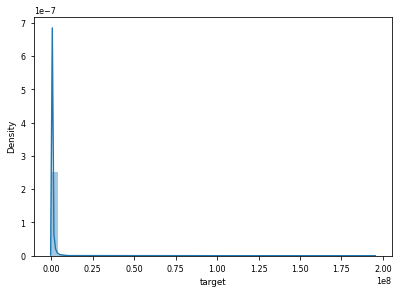

In [17]:
sns.distplot(data_d['target'])

In [18]:
data_d.target = np.log(data_d.target[data_d.target > 0])

<AxesSubplot:xlabel='target', ylabel='Density'>

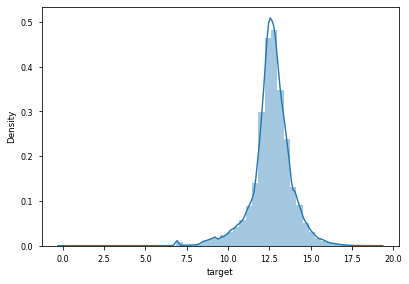

In [19]:
sns.distplot(data_d['target'])

Предварительное грубое удаление выбросов.

In [20]:
data_d['target'] = data_d[(data_d['target'] > 7.5)]['target']

# Спальни - приведение к численному виду.

In [21]:
data_d['beds'].unique()

array(['4', '3 Beds', '5 Beds', ..., '9,565 sqft', '1.74 acres',
       '8,479 sqft'], dtype=object)

In [22]:
data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor')[0])

Вспомогательная функция stirng_part со вложенной string_part_extract для выделения символьной части.

In [23]:
def string_part_extract(string, len_s, i, res_str):
    if i<len_s:
      
        if string[i].isdigit(): return string_part_extract(string, len_s, i+1, res_str)
        else:
    
            return string_part_extract(string, len_s, i+1, res_str+string[i])
    elif i==len_s:
    
        if string[i].isdigit(): 
           
            return res_str
        
        else:
       
            return (res_str+string[i])
    
    
    
    
def stirng_part(string):
    len_s = len(str(string))-1
    pus = ""
    return string_part_extract(str(string), len_s, 0, pus)

Вспомогательная функция, проверяет определенные слова в описании признака.

In [24]:
def subsrting_beds(source_string):
    list_of_strings = ['Bd','Bedrooms','Beds','Bed','bd','beds','bed','bedrooms']
    for substring in list_of_strings:
        if substring in source_string:
            return False
    return True

Предварительная обработка признака для систематизации словесных комментариев. (Для того, чтобы значимые величины не попали в выбросы.)

In [25]:
data_d = data_d.drop(np.where(data_d['beds'] == '# Bedrooms 1st Floor')[0])
data_d.beds = data_d.beds.apply(lambda x: 0 if subsrting_beds(stirng_part(x)) else x)
data_d.beds = data_d.beds.apply(lambda x: 0 if 'Bath' in str(x) else x)
data_d.beds = data_d.beds.apply(lambda x: 0 if x == '1-2 Beds' or x == '-- bd' else x)
data_d['beds'].unique()                        
data_d['beds'].value_counts() 

0          212870
3 Beds      53459
4 Beds      35418
2 Beds      26362
3 bd        12877
            ...  
23 bd           1
31 Beds         1
27 bd           1
26 bd           1
88 Beds         1
Name: beds, Length: 74, dtype: int64

Вспомогательная функция для выбора числового значения признака спальни.

In [26]:
def otbor(stroka,i):
    if i == len(stroka): return(int(stroka))
    elif stroka[i] == ' ':
            return (int(stroka[:i]))
    else: return otbor(stroka,i+1)
    

In [27]:
data_d.beds = data_d.beds.apply(lambda x: otbor(str(x),0))

In [28]:
data_d['beds'].unique()                        


array([ 0,  3,  5,  2,  4,  8,  6, 12,  7,  1,  9, 16, 13, 18, 10, 20, 26,
       64, 22, 11, 24, 14, 28, 32, 15, 36, 19, 25, 17, 27, 47, 23, 44, 31,
       34, 78, 48, 40, 33, 53, 51, 30, 39, 42, 21, 52, 46, 76, 88])

# Ванны - приведение к численному виду.

In [29]:
data_d['baths'].unique()   

array(['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3',
       'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5',
       '1,000', '7 Baths', '2.0', '3.0', 'Bathrooms: 1', '4.0',
       '2.1 Baths', '2.5 Baths', '1', 'Bathrooms: 3', '4.5', '6 Baths',
       'Bathrooms: 4', '3 ba', '5', '2,500', '5.5 Baths', '1.0',
       '5 Baths', '1.5', '4', '~', '2.5', '4,000', '3.5 Baths', '2,000',
       '3,000', '8.0', '1 ba', '3.5 ba', '0', '5.0', '1,500', '7.0',
       '1,250', '9 Baths', '2,250', '6.0', '12 Baths', '5.5', '3,500',
       '1.5 Baths', '2,750', 'Bathrooms: 6', '4.5 Baths', '750', '5.5+',
       '6', '10 Baths', '6 ba', 'Bathrooms: 19', '10.0', '1.5 ba', '4 ba',
       '12 ba', '2.5+', '8', '7.5+', 'Bathrooms: 10', '0 / 0', 'Sq. Ft. ',
       '5 ba', '4.5+', '18 Baths', '-- baths', 'Bathrooms: 7', '7', '18',
       '3.5+', '1.5+', '11 Baths', '5,000', '1.75 Baths', '9', '12.0',
       '1.1 Baths', '6.5', 'Bathrooms: 8', '10', '19 Baths',
       'Bathrooms: 9', '16 B

Вспомогательная функция для получения численного значения оборудования в ванной. Если значение некорректно, выдает ноль. (Также использовалась для этажей.)

In [30]:
def extract_num_recurr_bath(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr_bath(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    
    else: return(float(first_digit))
                        
def extract_num_bath(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return 0
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr_bath(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num_bath(stroka,len_s,i+1)

def main_extract_num_bath(stroka):   
    len_s=len(stroka)-1
    
    return extract_num_bath(stroka,len_s,0)

In [31]:
data_d.baths = data_d.baths.apply(lambda x: main_extract_num_bath(str(x)))

In [32]:
data_d['baths'].unique()   

array([3.50e+00, 3.00e+00, 2.00e+00, 8.00e+00, 0.00e+00, 1.00e+00,
       4.00e+00, 5.00e+00, 7.00e+00, 2.10e+00, 2.50e+00, 4.50e+00,
       6.00e+00, 5.50e+00, 1.50e+00, 9.00e+00, 1.20e+01, 7.50e+02,
       1.00e+01, 1.90e+01, 7.50e+00, 1.80e+01, 1.10e+01, 1.75e+00,
       1.10e+00, 6.50e+00, 1.60e+01, 1.30e+01, 1.40e+01, 8.50e+00,
       1.70e+01, 2.41e+02, 1.05e+01, 2.00e+01, 4.00e+01, 2.75e+00,
       2.40e+01, 2.20e+01, 2.25e+00, 3.10e+00, 3.25e+00, 3.20e+01,
       2.70e+01, 2.60e+01, 9.50e+00, 1.50e+01, 3.50e+01, 3.75e+00,
       2.90e+01, 1.16e+02, 2.10e+01, 5.20e+00, 1.45e+01, 7.60e+01,
       2.30e+01, 3.30e+00, 4.30e+01, 1.25e+00, 3.40e+01, 2.20e+00,
       5.50e+01, 2.50e+01, 1.25e+01, 4.40e+01, 5.00e-01, 4.25e+00,
       4.75e+00, 7.50e-01, 4.10e+00, 5.25e+00, 4.10e+01, 1.80e+00,
       3.60e+01, 3.00e+01, 2.80e+01, 2.80e+00, 6.40e+01, 1.15e+01,
       3.90e+01, 4.20e+01, 3.20e+00, 6.00e+01, 6.75e+00, 6.80e+01])

 # Камин

Вспомогательная функция для приведения признака числа каминов к численному виду.

In [33]:
def fireplaces_def(stroka):
    if stroka == 'yes': return 1
    elif stroka == 'Yes': return 1
    elif stroka == '1': return 1
    elif stroka == '2': return 2
    else: return 0

In [34]:
data_d['fireplace'].value_counts(3) 

yes                                                                     0.488348
Yes                                                                     0.202260
1                                                                       0.141046
2                                                                       0.023585
Not Applicable                                                          0.019328
                                                                          ...   
Free-standing, Insert, Wood                                             0.000010
Wood Burning, Attached Fireplace Doors/Screen, Electric, Gas Starter    0.000010
One, Living Room                                                        0.000010
FAMILYRM, Great Room, Living Room                                       0.000010
Ceiling Fan, SMAPL, Utility Connection, Walk-In Closets                 0.000010
Name: fireplace, Length: 1653, dtype: float64

In [35]:
data_d.fireplace = data_d.fireplace.apply(lambda x: fireplaces_def(str(x)))


In [36]:
data_d['fireplace'].unique()

array([0, 1, 2])

# Бассейн. Анализ.

In [37]:
data_d['private pool'].value_counts()

Yes    4181
Name: private pool, dtype: int64

In [38]:
data_d.loc[data_d['private pool'] == 'Yes']

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
205,For sale,Yes,Single Family,1403 Betton Rd,2.0,"{'atAGlanceFacts': [{'factValue': '1958', 'fac...",1,Tallahassee,"[{'rating': ['4/10', '5/10', '7/10'], 'data': ...","Total interior livable area: 2,361 sqft",32308,3,FL,NaN,302221,NaN,NaN,12.860999
321,For sale,Yes,Single Family,3296 Ledgewood Cir,3.0,"{'atAGlanceFacts': [{'factValue': '2017', 'fac...",0,Riverside,"[{'rating': ['4/10', '4/10', '6/10'], 'data': ...","Total interior livable area: 2,135 sqft",92503,3,CA,2.0,IV19242188,NaN,NaN,13.171154
355,For sale,Yes,Mobile / Manufactured,2250 N Broadway # 42,2.0,"{'atAGlanceFacts': [{'factValue': '1976', 'fac...",0,Escondido,"[{'rating': ['4/10', '4/10', '6/10'], 'data': ...","Total interior livable area: 1,536 sqft",92026,2,CA,0.0,190034991,NaN,NaN,11.686879
404,For sale,Yes,Single Family,24448 Epson Ct,3.0,"{'atAGlanceFacts': [{'factValue': '1987', 'fac...",0,Murrieta,"[{'rating': ['7/10', '6/10', '8/10'], 'data': ...","Total interior livable area: 1,832 sqft",92562,3,CA,1.0,SW19240910,NaN,NaN,13.709038
425,Pre-foreclosure / auction,Yes,Single Family,7632 Hillside Dr,2.0,"{'atAGlanceFacts': [{'factValue': '1964', 'fac...",1,Jacksonville,"[{'rating': ['5/10', '2/10', '4/10'], 'data': ...","Total interior livable area: 1,245 sqft",32221,3,FL,1.0,NaN,NaN,NaN,11.760590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
376627,For sale,Yes,Cooperative,1201 S Riverside Dr Phb # PHB,2.0,"{'atAGlanceFacts': [{'factValue': '1963', 'fac...",0,Pompano Beach,"[{'rating': ['6/10', '4/10', '3/10'], 'data': ...","Total interior livable area: 2,200 sqft",33062,3,FL,4.0,F10163349,NaN,NaN,13.296317
376686,For sale,Yes,Single Family,2609 S Marigold Ave,3.0,"{'atAGlanceFacts': [{'factValue': '1979', 'fac...",0,Ontario,"[{'rating': ['7/10', '6/10', '5/10'], 'data': ...","Total interior livable area: 1,726 sqft",91761,3,CA,2.0,IV19252050,NaN,NaN,13.079456
376694,For sale,Yes,Condo,5980 Shore Blvd S APT 312,3.0,"{'atAGlanceFacts': [{'factValue': '1972', 'fac...",0,Gulfport,"[{'rating': ['2/10', '2/10', '4/10'], 'data': ...","Total interior livable area: 2,210 sqft",33707,2,FL,9.0,U8064383,NaN,NaN,12.983101
376853,For sale,Yes,Townhouse,3188 NE Oregon St,4.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",1,Portland,"[{'rating': ['9/10', '7/10'], 'data': {'Distan...","Total interior livable area: 2,445 sqft",97232,4,OR,3.0,19591180,NaN,NaN,13.422320


Вывод: число домов с бассейнами незначительно (4181 из 377185), разброс цен для домов с бассейнами большой, явного влияния на цену нет. Можно не рассматривать.

 # propertyType

In [39]:
dd = data_d['propertyType'].value_counts(normalize=True)

In [40]:
data_d.propertyType = data_d.propertyType.apply(lambda x: 'sfh' if x in ['single-family home','Single Family','Single Family Home'] else x)

In [41]:
data_d['propertyType'].value_counts(normalize=True)

sfh                                                            0.545488
condo                                                          0.075830
lot/land                                                       0.060014
Condo                                                          0.048360
townhouse                                                      0.033476
                                                                 ...   
Custom, Elevated, Other                                        0.000003
Contemporary, Farmhouse                                        0.000003
2 Stories, Traditional, Mediterranean, Texas Hill Country      0.000003
1 Story, Contemporary, Traditional, Mediterranean              0.000003
Bilevel, Converted Dwelling, Loft with Bedrooms, Condo/Unit    0.000003
Name: propertyType, Length: 1278, dtype: float64

Преобразование к численному виду.

In [42]:
data_d['propertyType'] = data_d['propertyType'].astype('category')
data_d['propertyType_cat'] = data_d['propertyType'].cat.codes

 # площадь

Вспомогательная функция для получения численного значения площади. Если значение некорректно, выдает ноль.

In [43]:
def extract_num_recurr_sqft(stroka,first_digit,len_s,i):
    if i == len_s and stroka[i].isdigit():
        return (float(first_digit + str(stroka[i])))
    elif i < len_s and (stroka[i].isdigit() or stroka[i] == '.'):
        return extract_num_recurr_sqft(stroka, (first_digit + str(stroka[i])), len_s, i+1)
    elif i < len_s and stroka[i] == ',':
        return extract_num_recurr_sqft(stroka, first_digit, len_s, i+1)
    else: return(float(first_digit))
                        
def extract_num_sqft(stroka,len_s,i):
  
    if i == len_s and not stroka[i].isdigit():
        return 0
    elif i == len_s and stroka[i].isdigit():
        return float(stroka[i])
    elif i < len_s and stroka[i].isdigit():
        return extract_num_recurr_sqft(stroka,str(stroka[i]),len_s,i+1)
    else: return extract_num_sqft(stroka,len_s,i+1)

def main_extract_num_sqft(stroka):   
    len_s=len(stroka)-1
    
    return extract_num_sqft(stroka,len_s,0)

In [44]:
data_d.sqft = data_d.sqft.apply(lambda x: main_extract_num_sqft(str(x)))

In [45]:
data_d.sqft = data_d.sqft.apply(lambda x: data_d['sqft'].median() if x == 0 else x)

In [46]:
data_d['sqft'].value_counts()

1653.0       53336
1200.0        1426
1000.0        1027
1500.0        1014
1800.0         988
             ...  
5728968.0        1
12503.0          1
8815.0           1
15391.0          1
13870.0          1
Name: sqft, Length: 9895, dtype: int64

# Признаки город и штат

Объединение в один признак, приведение к численному виду.

In [47]:
data_d['sity_state']=data_d['city'].astype(str) + " " +data_d['state'].astype(str)


In [48]:
data_d['sity_state'] = data_d['sity_state'].astype('category')
data_d['sity_state_cat'] = data_d['sity_state'].cat.codes

 # Stories (надеюсь, это этажи)

In [49]:
data_d['stories'].value_counts()

1.0                                  67454
2.0                                  55283
1                                    23086
2                                    18146
3.0                                  11275
                                     ...  
Manufactured Home, Non-Site Built        1
Bedroom - Split Plan                     1
78                                       1
One, Two, Multi/Split                    1
65.0                                     1
Name: stories, Length: 348, dtype: int64

In [50]:
data_d.stories = data_d.stories.apply(lambda x: main_extract_num_bath(str(x)))


In [51]:
data_d['stories'].value_counts()

0.0       174303
1.0        93924
2.0        79240
3.0        17212
9.0         3386
           ...  
1120.0         1
2.2            1
1002.0         1
96.0           1
65.0           1
Name: stories, Length: 85, dtype: int64

 # Status

In [52]:
data_d['status'].value_counts()

for sale                156104
Active                  105207
For sale                 43465
foreclosure               6426
New construction          5475
                         ...  
Contingent   No Show         1
Coming soon: Oct 24.         1
Coming soon: Oct 21.         1
Coming soon: Nov 14.         1
Coming soon: Dec 23.         1
Name: status, Length: 159, dtype: int64

In [53]:
data_d.status = data_d.status.apply(lambda x: 'for_sale' if x in ['for sale','For sale'] else x)

Я бы предположила, что active - это на самом деле тоже for sale, но на всякий случай пока оставлю.

In [54]:
data_d['status'].value_counts()

for_sale                   199569
Active                     105207
foreclosure                  6426
New construction             5475
Pending                      4702
                            ...  
Coming soon: Oct 29.            1
Coming soon: Dec 15.            1
Pending W/Backup Wanted         1
Pending Backups Wanted          1
Coming soon: Dec 23.            1
Name: status, Length: 158, dtype: int64

Приведение к численному виду.

In [55]:
data_d['status'] = data_d['status'].astype('category')
data_d['status_cat'] = data_d['status'].cat.codes

# Выбор предварительного датафрейма для модели

In [56]:
data_d.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 377184 entries, 0 to 377184
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   status            337266 non-null  category
 1   private pool      4181 non-null    object  
 2   propertyType      342451 non-null  category
 3   street            377182 non-null  object  
 4   baths             377184 non-null  float64 
 5   homeFacts         377184 non-null  object  
 6   fireplace         377184 non-null  int64   
 7   city              377150 non-null  object  
 8   schools           377184 non-null  object  
 9   sqft              377184 non-null  float64 
 10  zipcode           377184 non-null  object  
 11  beds              377184 non-null  int64   
 12  state             377184 non-null  object  
 13  stories           377184 non-null  float64 
 14  mls-id            24942 non-null   object  
 15  PrivatePool       40311 non-null   object  
 16  Ml

In [57]:
data_d_preliminary=data_d[['status_cat','propertyType_cat','baths','fireplace','sqft','beds','stories','sity_state_cat','target']]

In [58]:
data_d_preliminary

,status_cat,propertyType_cat,baths,fireplace,sqft,beds,stories,sity_state_cat,target
0,4,1275,3.5,0,2900.0,0,0.0,1863,12.943237
1,154,1275,3.0,0,1947.0,3,2.0,1872,12.644328
2,154,1275,2.0,1,3000.0,3,1.0,1149,14.878496
3,154,1275,8.0,1,6457.0,5,3.0,486,14.688894
4,154,1272,0.0,0,1653.0,0,0.0,1476,8.517193
...,...,...,...,...,...,...,...,...,...
377180,-1,1275,6.0,0,4017.0,0,0.0,1239,14.037854
377181,154,1270,3.0,0,2000.0,3,9.0,356,13.422466
377182,154,1275,3.0,0,1152.0,3,2.0,963,13.176852
377183,-1,-1,0.0,0,1653.0,0,0.0,906,10.448715


In [59]:
data_d_preliminary.isnull().sum()

status_cat             0
propertyType_cat       0
baths                  0
fireplace              0
sqft                   0
beds                   0
stories                0
sity_state_cat         0
target              3726
dtype: int64

# Визуализация

(9.5, -0.5)

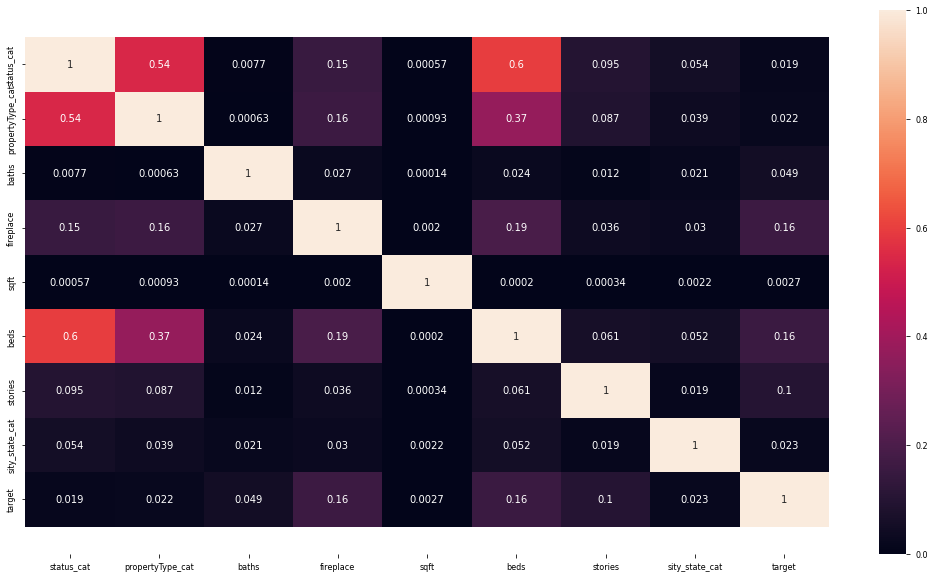

In [60]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_preliminary.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

In [61]:
#  подготовка данных для графиков
x1 = data_d_preliminary['propertyType_cat']
x2 = data_d_preliminary['status_cat']
x3 = data_d_preliminary['baths']
x4 = data_d_preliminary['fireplace']
x5 = data_d_preliminary['sqft']
x6 = data_d_preliminary['beds']
x7 = data_d_preliminary['stories']
x8 = data_d_preliminary['sity_state_cat']

y = data_d_preliminary['target']

Text(0.5, 1.0, 'Зависимость цены от статуса продажи')

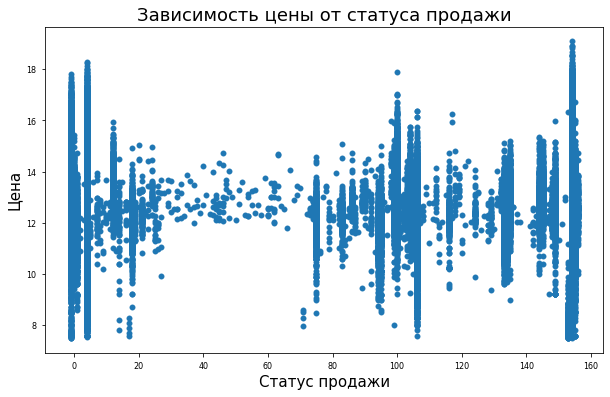

In [62]:
plt.figure(figsize = (10,6))
plt.scatter(x2, y)
 
# добавим подписи
plt.xlabel('Статус продажи', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от статуса продажи', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от типа недвижимости')

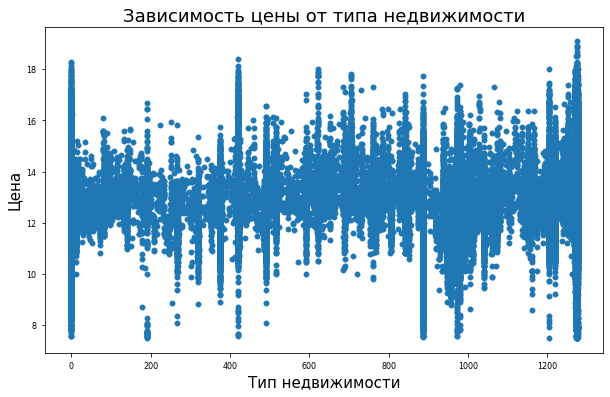

In [63]:
plt.figure(figsize = (10,6))
plt.scatter(x1, y)
 
# добавим подписи
plt.xlabel('Тип недвижимости', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от типа недвижимости', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от наличия камина')

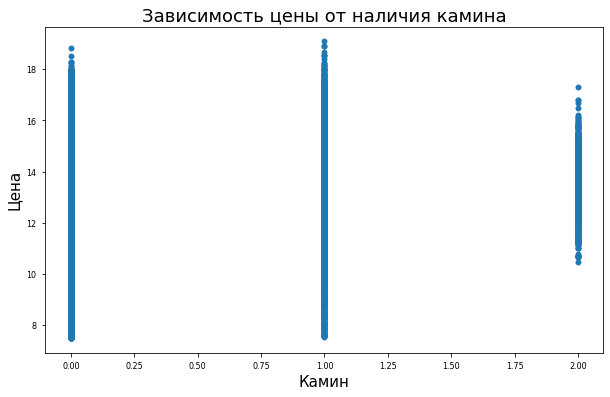

In [64]:
plt.figure(figsize = (10,6))
plt.scatter(x4, y)
 
# добавим подписи
plt.xlabel('Камин', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от наличия камина', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от площади')

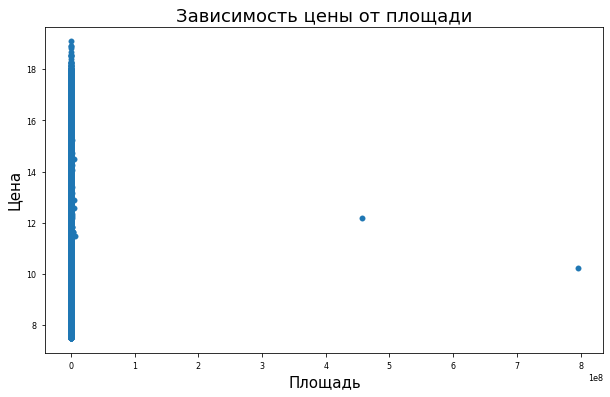

In [65]:
plt.figure(figsize = (10,6))
plt.scatter(x5, y)
 
# добавим подписи
plt.xlabel('Площадь', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от площади', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от количества комнат')

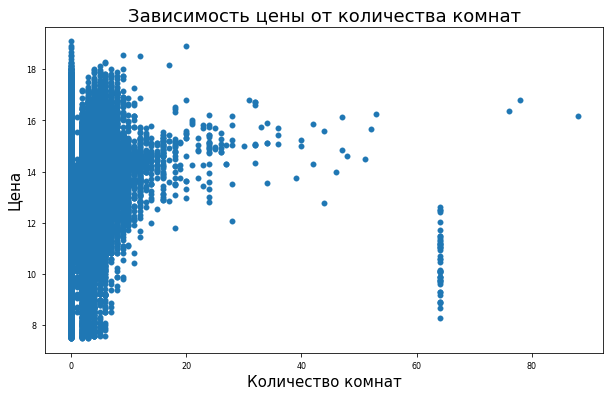

In [66]:
plt.figure(figsize = (10,6))
plt.scatter(x6, y)
 
# добавим подписи
plt.xlabel('Количество комнат', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от количества комнат', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от этажа')

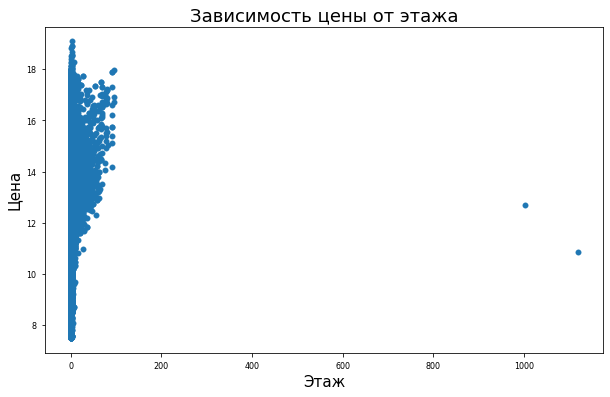

In [67]:
plt.figure(figsize = (10,6))
plt.scatter(x7, y)
 
# добавим подписи
plt.xlabel('Этаж', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от этажа', fontsize = 18)

Text(0.5, 1.0, 'Зависимость цены от города')

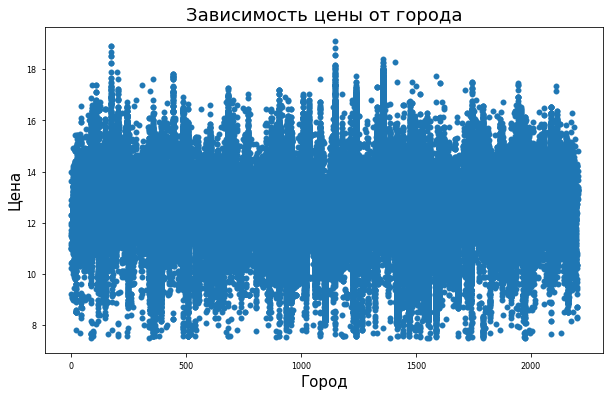

In [68]:
plt.figure(figsize = (10,6))
plt.scatter(x8, y)
 
# добавим подписи
plt.xlabel('Город', fontsize = 15)
plt.ylabel('Цена', fontsize = 15)
plt.title('Зависимость цены от города', fontsize = 18)

<AxesSubplot:xlabel='status_cat'>

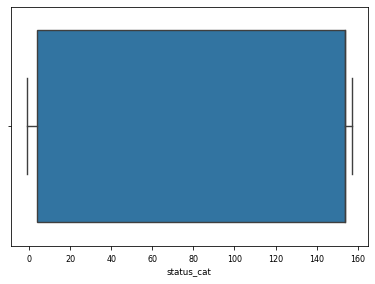

In [69]:
#data_d_preliminary=data_d[['status_cat','propertyType_cat','baths','fireplace','sqft','beds','stories','sity_state_cat','target']]
sns.boxplot(data_d_preliminary['status_cat'])

<AxesSubplot:xlabel='propertyType_cat'>

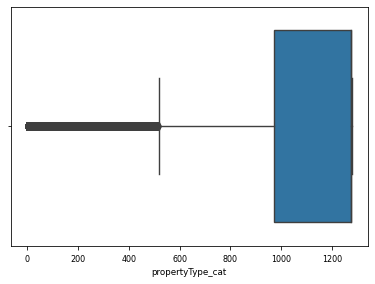

In [70]:
sns.boxplot(data_d_preliminary['propertyType_cat'])

<AxesSubplot:xlabel='propertyType_cat'>

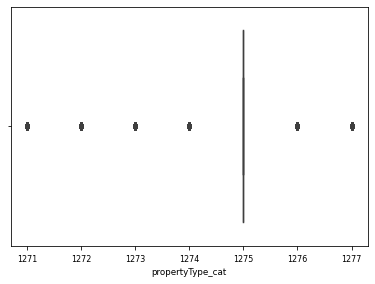

In [71]:
data_d_preliminary['propertyType_cat'] = data_d_preliminary[(data_d_preliminary['propertyType_cat'] > 1270)]['propertyType_cat']
sns.boxplot(data_d_preliminary['propertyType_cat'])

<AxesSubplot:xlabel='baths'>

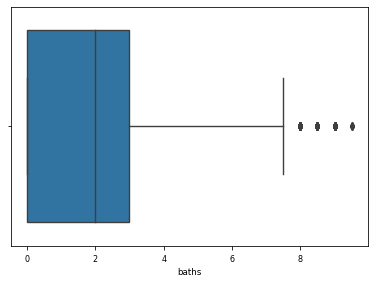

In [72]:
data_d_preliminary['baths'] = data_d_preliminary[(data_d_preliminary['baths'] < 10)]['baths']
sns.boxplot(data_d_preliminary['baths'])

<AxesSubplot:xlabel='fireplace'>

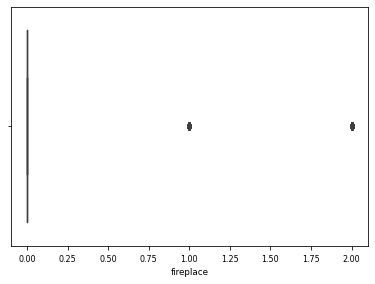

In [73]:
sns.boxplot(data_d_preliminary['fireplace'])

<AxesSubplot:xlabel='sqft'>

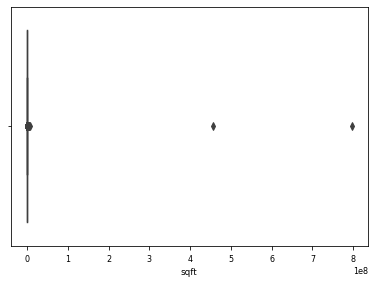

In [74]:
sns.boxplot(data_d_preliminary['sqft'])

<AxesSubplot:xlabel='beds'>

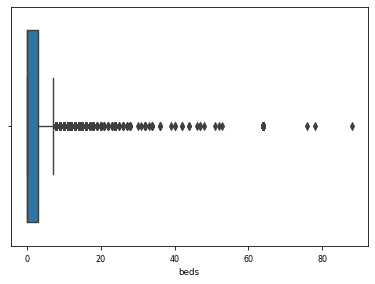

In [75]:
sns.boxplot(data_d_preliminary['beds'])

<AxesSubplot:xlabel='beds'>

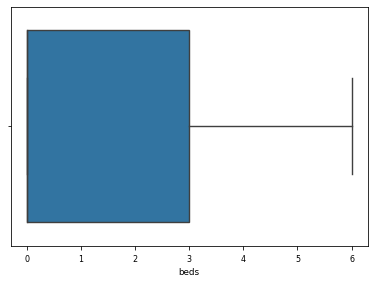

In [76]:
data_d_preliminary['beds'] = data_d_preliminary[(data_d_preliminary['beds'] < 7)]['beds']
sns.boxplot(data_d_preliminary['beds'])

<AxesSubplot:xlabel='stories'>

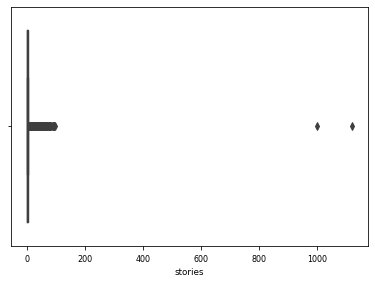

In [77]:
sns.boxplot(data_d_preliminary['stories'])

<AxesSubplot:xlabel='stories'>

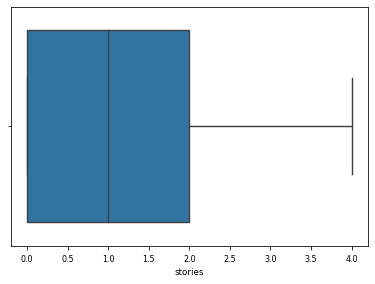

In [78]:
data_d_preliminary['stories'] = data_d_preliminary[(data_d_preliminary['stories'] < 5)]['stories']
sns.boxplot(data_d_preliminary['stories'])

<AxesSubplot:xlabel='sity_state_cat'>

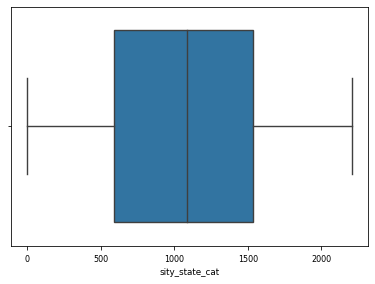

In [79]:
sns.boxplot(data_d_preliminary['sity_state_cat'])

<AxesSubplot:xlabel='sity_state_cat'>

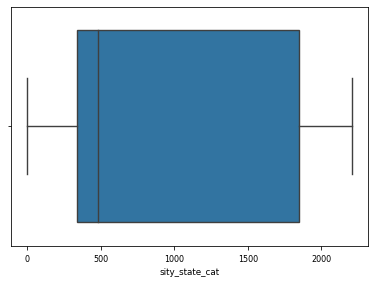

In [80]:

data_d_preliminary['sity_state_cat'] = data_d_preliminary[(data_d_preliminary['sity_state_cat'] < 500 ) | (data_d_preliminary['sity_state_cat'] > 1700)]['sity_state_cat']
sns.boxplot(data_d_preliminary['sity_state_cat'])

377185

In [81]:
data_d_preliminary.isnull().sum()

status_cat               0
propertyType_cat    145550
baths                 1258
fireplace                0
sqft                     0
beds                  3237
stories               7865
sity_state_cat      221349
target                3726
dtype: int64

In [82]:
values = {'propertyType_cat':1275,'sity_state_cat':0}
data_d_preliminary = data_d_preliminary.fillna(value=values)

In [83]:
data_d_preliminary = data_d_preliminary.dropna()

In [84]:
data_d_preliminary.isnull().sum()

status_cat          0
propertyType_cat    0
baths               0
fireplace           0
sqft                0
beds                0
stories             0
sity_state_cat      0
target              0
dtype: int64

(9.5, -0.5)

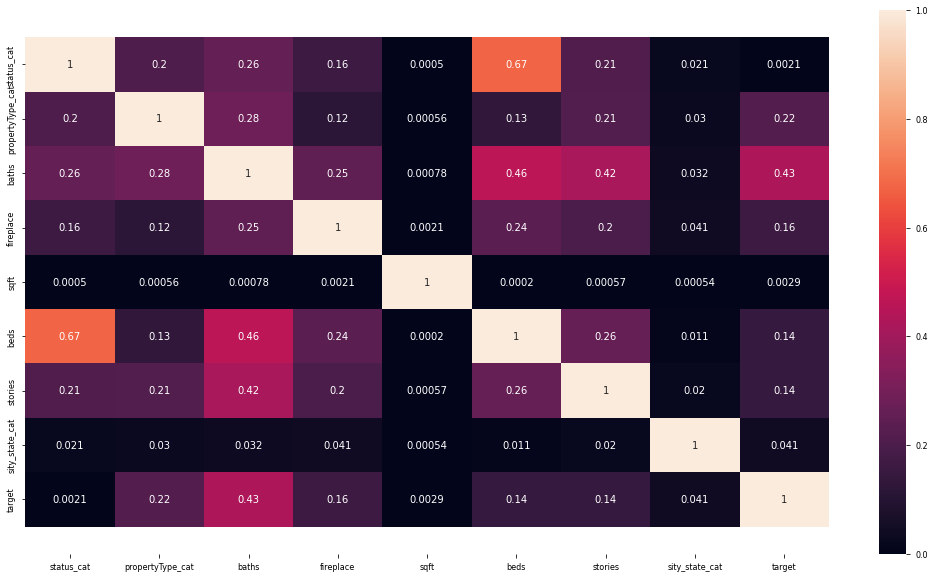

In [85]:
plt.figure(figsize=(18, 10))
ax = sns.heatmap(data_d_preliminary.corr().abs(), vmin=0, vmax=1, annot = True)
i, k = ax.get_ylim()
ax.set_ylim(i+0.5, k-0.5)

> # Грубая модель

In [86]:
X = data_d_preliminary[['status_cat','propertyType_cat','baths','fireplace','sqft','beds','stories','sity_state_cat']]
y = data_d_preliminary[['target']]

X1 = data_d_preliminary[['sity_state_cat','baths','beds']]

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, 
                                                    train_size=0.67, 
                                                    random_state=RANDOM_SEED)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [89]:
extra_tree = ExtraTreesRegressor(n_estimators = 400, 
                                 n_jobs=-1, random_state=RANDOM_SEED)
extra_tree.fit(X_train, y_train)
predict_extra_tree = extra_tree.predict(X_test)
predict_extra_tree

np.array(y_test.index.values)

# оцениваем точность
print(mape(np.array(y_test.index.values), predict_extra_tree))
#print((mape_log(y_test, predict_extra_tree)))
#pprint(f"MAPE: {(mape_log(y_test, predict_extra_tree))*100:0.2f}%")


inf


In [90]:
catboost = CatBoostRegressor(iterations = 1000,
                          learning_rate = 0.5,
                          random_seed = RANDOM_SEED,
                          eval_metric='RMSE',
                          depth = 10,
                          l2_leaf_reg = 1)
catboost.fit(X_train, y_train,
         
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.0342014	test: 1.0415707	best: 1.0415707 (0)	total: 99.8ms	remaining: 1m 39s
100:	learn: 0.9348053	test: 0.9426456	best: 0.9426456 (100)	total: 3.33s	remaining: 29.7s
200:	learn: 0.9309676	test: 0.9407358	best: 0.9407050 (199)	total: 6.56s	remaining: 26.1s
300:	learn: 0.9295649	test: 0.9406113	best: 0.9405778 (294)	total: 9.77s	remaining: 22.7s
400:	learn: 0.9288569	test: 0.9406974	best: 0.9405778 (294)	total: 13s	remaining: 19.5s
500:	learn: 0.9284194	test: 0.9409040	best: 0.9405778 (294)	total: 16.3s	remaining: 16.2s
600:	learn: 0.9281723	test: 0.9410516	best: 0.9405778 (294)	total: 19.5s	remaining: 12.9s
700:	learn: 0.9279860	test: 0.9411331	best: 0.9405778 (294)	total: 22.8s	remaining: 9.73s
800:	learn: 0.9278696	test: 0.9412647	best: 0.9405778 (294)	total: 26s	remaining: 6.47s
900:	learn: 0.9277741	test: 0.9413726	best: 0.9405778 (294)	total: 29.6s	remaining: 3.26s
999:	learn: 0.9277025	test: 0.9414531	best: 0.9405778 (294)	total: 32.9s	remaining: 0us

bestTest = 0.9405

In [91]:
predict_catboost = catboost.predict(X_test)

print(f"MAPE: {(mape_log(y_test, predict_catboost))*100:0.2f}%")

ValueError: Unable to coerce to Series, length must be 1: given 119346

In [92]:
print_regression_metrics(y_test, predict_catboost)

MSE = 0.88, RMSE = 0.94


In [93]:
model = LinearRegression()


In [94]:
model.fit(X_train, y_train)

LinearRegression()

In [95]:
y_pred = model.predict(X_test)


In [96]:
from sklearn import metrics

In [97]:
print('Root Mean Squared Error (RMSE):', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Root Mean Squared Error (RMSE): 1.03604118589327


In [98]:
print('R2:', np.round(metrics.r2_score(y_test, y_pred), 2))

R2: 0.19
